11-18 November 2016

Notebook for testing sklearn algorithms for selection of $3.5<z<5$ quasars from SDSS+SpIES.

# Training Data
Training data sets were made as follows (see 12 April 2016 README entry):

maketrainhighz2flup_2016.py

Input:<br>
/Users/gtr/Work/data/ALLWISE/fromadam2016/GTR-ADM-QSO-ir-master_matches2016.fits<br>
/Users/gtr/Work/data/ALLWISE/fromadam2016/GTR-ADM-QSO-ir-master_nonmatches2016.every100.fits

Output:<br>
GTR-ADM-QSO-ir-master-sweeps_qsomatches_lup_train.photoz_in.2016.dat<br>
GTR-ADM-QSO-ir_labels-nonflagged_qsohighz_2016.dat<br>
GTR-ADM-QSO-ir_classifiers-nonflagged_qsohighz_2016.dat<br>
GTR-ADM-QSO-ir_others-nonflagged_qsohighz_2016.dat<br>
GTR-ADM-QSO-ir_all-nonflagged_qsohighz_2016.dat<br>

highz_findbw_lup_2016.csh<br>
computes bandwidths
and produces "starclean" files:<br>

GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_colors_starclean.dat<br> 
GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_others_starclean.dat<br>
GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_labels_starclean.dat<br>

693559 objects in all<br>
4193 quasars<br>
689365 stars<br>

Merged these together (15 November 2016) with TOPCAT to produce<br>
GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean.fits

In [45]:
# Read in data file
%matplotlib inline
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
data = Table.read('GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean.fits')

# X is in the format need for all of the sklearn tools, it just has the colors
X = np.vstack([ data['ug'], data['gr'], data['ri'], data['iz'], data['zs1'], data['s1s2']]).T
y = np.array(data['labels'])
#y = np.array(data['zspec'])

# If we want to make a scaled version of X
from sklearn.preprocessing import StandardScaler 
XS = StandardScaler().fit_transform(X)

print data.keys()

#Include more attributes to see if that helps at all with classification
XX = np.vstack([ data['ug'], data['gr'], data['ri'], data['iz'], data['zs1'], data['s1s2'], data['imag'], data['extinctu'], data['morph']]).T

['ug', 'gr', 'ri', 'iz', 'zs1', 's1s2', 'ra', 'dec', 'iflux', 'zspec', 'extinctu', 'imag', 'morph', 'labels']


---
## Neural Network Classification

Let's start by trying a neural network.  (More because that's the last thing that I taught than anything else.)

In [46]:
# Neural Network
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Split the training data into training and test sets for cross-validation
Xtrain, Xtest, ytrain, ytest = train_test_split(Xs, y, test_size=0.25, random_state=42)

# Instantiate the classifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
# Train the classifier with the training subset
clf.fit(Xtrain, ytrain)

# Now predict the labels for the test data
ypred = clf.predict(Xtest)

In [47]:
# The classification report gives:
# efficiency = precision
# completeness = recall
# while the f1-score is a combination of the two
print(classification_report(ytest, ypred, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.91      0.79      0.85      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



In [48]:
# The above only classifies 25% of the data.  Do a cross-validation instead which
# averages over all of the results, using N different subsamples for testing
N = 5
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
ypredCV = cross_val_predict(clf, X, y, cv=N)
print(classification_report(y, ypredCV, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.78      0.70      0.74      4193
      stars       1.00      1.00      1.00    689365

avg / total       1.00      1.00      1.00    693558



So just 70% completeness and 78% efficiency (i.e., 22% contam).  Not so great.

---
## SVM Classification

In [10]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(Xtrain, ytrain)

ypredSVM = svm.predict(Xtest)
print(classification_report(ytest, ypredSVM, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.95      0.79      0.87      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



Pretty good!  79% completeness and 95% efficiency.

In [12]:
# Do it again with scaled data to see if that makes any difference
# It doesn't seem to for colors alone, but might for other attributes?
XS = StandardScaler().fit_transform(X)
XStrain, XStest, yStrain, yStest = train_test_split(XS, y, test_size=0.25, random_state=42)

svm = SVC()
svm.fit(XStrain, yStrain)

ySpredSVM = svm.predict(XStest)
print(classification_report(yStest, ySpredSVM, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.95      0.79      0.87      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



---
## Random Forest Classification

Now we'll try a DecisionTree, a RandomForest, and an ExtraTrees classifier

In [40]:
# Random Forests, etc.
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

clfDTC = DecisionTreeClassifier(max_depth=None, min_samples_split=2)
clfRFC = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2,n_jobs=-1)
clfETC = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2)

clfDTC.fit(Xtrain, ytrain)
clfRFC.fit(Xtrain, ytrain)
clfETC.fit(Xtrain, ytrain)

ypredDTC = clfDTC.predict(Xtest)
ypredRFC = clfRFC.predict(Xtest)
ypredETC = clfETC.predict(Xtest)

In [41]:
print clfDTC.feature_importances_
print clfRFC.feature_importances_
print clfETC.feature_importances_

print(classification_report(ytest, ypredDTC, target_names=['QSOs', 'stars']))
print(classification_report(ytest, ypredRFC, target_names=['QSOs', 'stars']))
print(classification_report(ytest, ypredETC, target_names=['QSOs', 'stars']))

[ 0.09442115  0.36931485  0.24824577  0.14277713  0.10071247  0.04452864]
[ 0.15190084  0.30173106  0.21459495  0.14105031  0.1157865   0.07493635]
[ 0.19236013  0.2647021   0.20571085  0.1340392   0.11219948  0.09098824]
             precision    recall  f1-score   support

       QSOs       0.79      0.78      0.79      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390

             precision    recall  f1-score   support

       QSOs       0.93      0.79      0.86      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390

             precision    recall  f1-score   support

       QSOs       0.93      0.76      0.84      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



Of these the Random Forest is best (and is better than the Neural Network).   Though I haven't tried to optimize the parameters of each.  The RF is giving a completeness of 79% and a 7% contamination (93% efficiency).

---
## Bagging

Now we'll try a bagging classifier, based on K Nearest Neighbors.

In [52]:
# Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=1.0, n_jobs=-1)
bagging.fit(Xtrain, ytrain)
ypredBag = bagging.predict(Xtest)
                           
print(classification_report(ytest, ypredBag, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.95      0.80      0.87      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



This seems to work better than the RandomForest.  Might be worth trying to optimize the parameters for this.

In [53]:
# Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(n_neighbors=7), max_samples=0.5, max_features=1.0, n_jobs=-1)
bagging.fit(Xtrain, ytrain)
ypredBag = bagging.predict(Xtest)
                           
print(classification_report(ytest, ypredBag, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.95      0.79      0.86      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



Basically the same with 7 neighbors instead of the default of 5.  Try cross-validation.

In [54]:
N = 5
clf = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=1.0, n_jobs=-1)
ypredCV = cross_val_predict(clf, X, y, cv=N)
print(classification_report(y, ypredCV, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.93      0.76      0.84      4193
      stars       1.00      1.00      1.00    689365

avg / total       1.00      1.00      1.00    693558



Overall: 76% Completness and 93% Efficiency.  Good!

---
## Boosting

Now try a boosting-based classifier.

In [47]:
# Boosting
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
boost = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3)
boost.fit(Xtrain, ytrain)
ypredBoost = boost.predict(Xtest)

print f1_score(ytest, ypredBoost)
print(classification_report(ytest, ypredBoost, target_names=['QSOs', 'stars']))
print boost.feature_importances_

0.999098150774
             precision    recall  f1-score   support

       QSOs       0.91      0.78      0.84      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390

[ 0.27452318  0.21624787  0.23767653  0.11637924  0.09736527  0.05780791]


Also pretty good, but not the best so far.  This algorithm outputs the importances of the features, which shows that $u-g$ is the most important with $r-i$ being next.

The main parameter for boosting is the depth of the underlying trees.  Let's make that a parameter and do a grid search over a range of depths.  The training set should always improve with greater depth, but the test set will plateau.  That's the value that we want for the depth.

In [69]:
# Depth-optimized Boosting
depth = np.arange(1, 10)
score_test = np.zeros(len(depth))
score_train = np.zeros(len(depth))
i_best = 0
z_fit_best = None

# Loop over the depths
for i, d in enumerate(depth):
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=d) 
    clf.fit(Xtrain, ytrain)

    ypredtrain = clf.predict(Xtrain)
    # We need some way to decide what is best
    # Try using the f1_score and comparing the values for the different depths
    score_train[i] = f1_score(ytrain, ypredtrain)
   
    ypredtest = clf.predict(Xtest)
    score_test[i] = f1_score(ytest, ypredtest)

    if score_test[i] >= score_test[i_best]:
        i_best = i
        ybest = ypredtest

best_depth = depth[i_best]

# Give the best depth and the corresponding classification report.
print best_depth
print(classification_report(ytest, ybest, target_names=['QSOs', 'stars']))

3
             precision    recall  f1-score   support

       QSOs       0.91      0.73      0.81      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



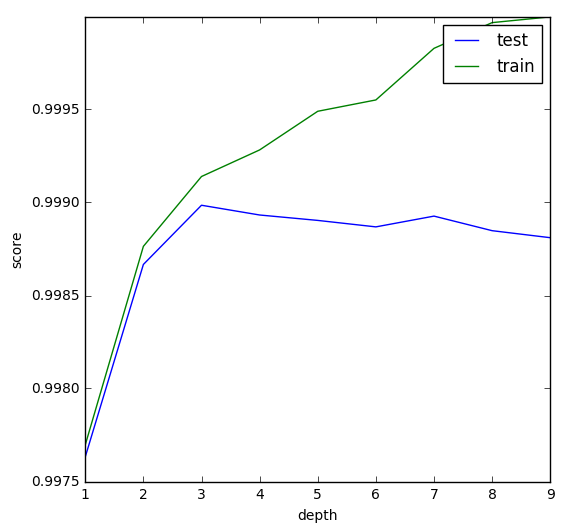

In [61]:
# Plot the f1 score vs. depth
fig = plt.figure(figsize=(6, 6))
plt.plot(depth,score_test,label='test')
plt.plot(depth,score_train,label='train')
plt.xlabel("depth")
plt.ylabel("score")
plt.legend()
plt.show()

This suggests that a depth of 3 is optimal.

---
RandomForests were better than Boosting, so let's try optimizing the depth for RandomForests.

In [64]:
# Depth-optimized Random Forest
depth = np.arange(10, 21)
score_test = np.zeros(len(depth))
score_train = np.zeros(len(depth))
i_best = 0
z_fit_best = None

for i, d in enumerate(depth):
    clf = RandomForestClassifier(n_estimators=10, max_depth=d, min_samples_split=2,n_jobs=-1)
    clf.fit(Xtrain, ytrain)

    ypredtrain = clf.predict(Xtrain)
    score_train[i] = f1_score(ytrain, ypredtrain)
   
    ypredtest = clf.predict(Xtest)
    score_test[i] = f1_score(ytest, ypredtest)

    if score_test[i] >= score_test[i_best]:
        i_best = i
        ybest = ypredtest

best_depth = depth[i_best]
print best_depth
print(classification_report(ytest, ybest, target_names=['QSOs', 'stars']))

15
             precision    recall  f1-score   support

       QSOs       0.95      0.78      0.85      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



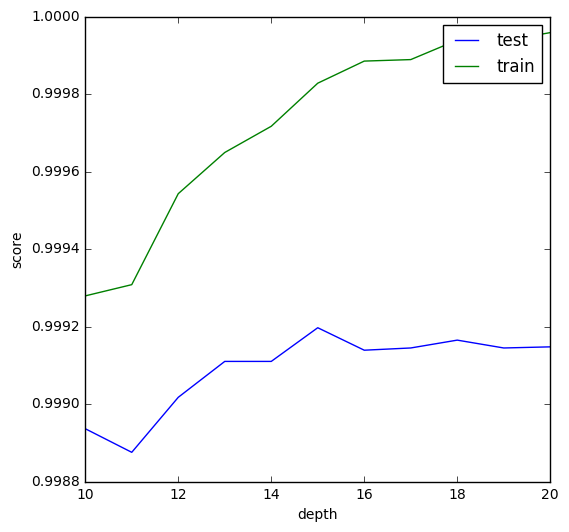

In [65]:
fig = plt.figure(figsize=(6, 6))
plt.plot(depth,score_test,label='test')
plt.plot(depth,score_train,label='train')
plt.xlabel("depth")
plt.ylabel("score")
plt.legend()
plt.show()

So far a `depth=15` RandomForest is giving the best results:

78% Completeness
5% Contamination

Though we might be able to optimize more by tweaking the other paramters.

In [73]:
# Try increasing the number of estimators
clf = RandomForestClassifier(n_estimators=20, max_depth=15, min_samples_split=2, n_jobs=-1)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

print(classification_report(ytest, ypred, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.95      0.77      0.85      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



Somehow this isn't quite as good, so stick with 10 estimators.

But first need to produce classifications for all using cross-validation and the parameters above.

Set `random_state` so that it is reproducible.

In [55]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=15, min_samples_split=2, n_jobs=-1, random_state=42)
N=5
ypredCV = cross_val_predict(clf, X, y, cv=N)

print(classification_report(y, ypredCV, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.92      0.79      0.85      4193
      stars       1.00      1.00      1.00    689365

avg / total       1.00      1.00      1.00    693558



Final result is 79% completeness and 8% contamination.

Should output the classification vector and do some exploring in TOPCAT with it.

Create a new Table column for `data` filled with the predicted $y$ values.  Then write it out as FITS.

In [57]:
data['ypred'] = ypredCV
data.write('GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean_class.fits', format='fits')

In [59]:
qq = ((data['labels']==0) & (data['ypred']==0))
ss = ((data['labels']==1) & (data['ypred']==1))
qs = ((data['labels']==0) & (data['ypred']==1))
sq = ((data['labels']==1) & (data['ypred']==0))
dataqq = data[qq]
datass = data[ss]
dataqs = data[qs]
datasq = data[sq]

print len(dataqq), "quasars selected as quasars"
print len(dataqs), "quasars selected as stars"
print len(datasq), "stars selected as quasars"

3300 quasars selected as quasars
893 quasars selected as stars
288 stars selected as quasars


What is interesting is that about half of the "stars" are quasars with $\lesssim3.5$.
So, the contamination is more like 4% than 8%.

Similarly, most of the failed quasars are at $z\gtrsim3$, which isn't all that surprising.

## Comparison with KDE Results
    
Assuming class1 is stars and class2 is quasars:<br>
  689365 true stars.  4193 true quasars.<br>
  690189 points were labeled as stars.<br>
  3369 points were labeled as quasars.<br><br>
  689273 out of 689365 stars were labeled as stars (99.99%).<br>
  92 out of 689365 stars were labeled as quasars (0.01335%).<br>
  916 out of 4193 quasars were labeled as stars (21.85%).<br>
  3277 out of 4193 quasars were labeled as quasars (78.15%).<br><br>
Overall Accuracy: 99.85%<br>
Weighted Accuracy: 89.07%<br>
Completeness: 78.15%<br>
Efficiency: 97.27%<br>
Rating: 0.7602<br>

This is about as good as the KDE results (at least for self classification), which got 78% completeness with 97% efficiency (where some of those stars classified as quasars are also likely $z\sim3.5$).  The combination of these suggests that the candidate list that John is using should has 3% or less contamination.  We can check that by also testing the photo-z's.

Make a few plots illustrating that not all of the contamination is from stars (but is instead from $z\lesssim3.5$).

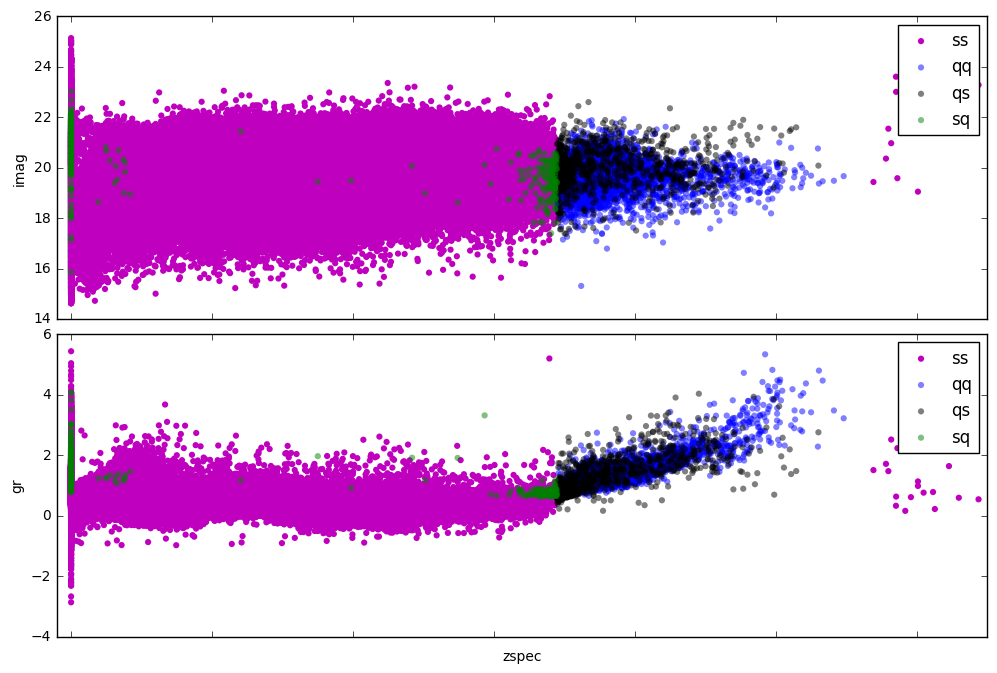

In [68]:
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(hspace=0.05)
ax1 = fig.add_subplot(211)
ax1.xaxis.set_major_formatter(plt.NullFormatter())
plt.scatter(datass['zspec'],datass['imag'],label='ss',edgecolor='None',color='m')
plt.scatter(dataqq['zspec'],dataqq['imag'],label='qq',edgecolor='None',color='b',alpha=0.5)
plt.scatter(dataqs['zspec'],dataqs['imag'],label='qs',edgecolor='None',color='k',alpha=0.5)
plt.scatter(datasq['zspec'],datasq['imag'],label='sq',edgecolor='None',color='g',alpha=0.5)
plt.legend(scatterpoints=1)
plt.xlim([-0.1,6.5])
plt.xlabel('zspec')
plt.ylabel('imag')

ax2 = fig.add_subplot(212, sharex=ax1)
plt.scatter(datass['zspec'],datass['gr'],label='ss',edgecolor='None',color='m')
plt.scatter(dataqq['zspec'],dataqq['gr'],label='qq',edgecolor='None',color='b',alpha=0.5)
plt.scatter(dataqs['zspec'],dataqs['gr'],label='qs',edgecolor='None',color='k',alpha=0.5)
plt.scatter(datasq['zspec'],datasq['gr'],label='sq',edgecolor='None',color='g',alpha=0.5)
plt.legend(scatterpoints=1)
plt.xlim([-0.1,6.5])
plt.xlabel('zspec')
plt.ylabel('gr')

plt.show()

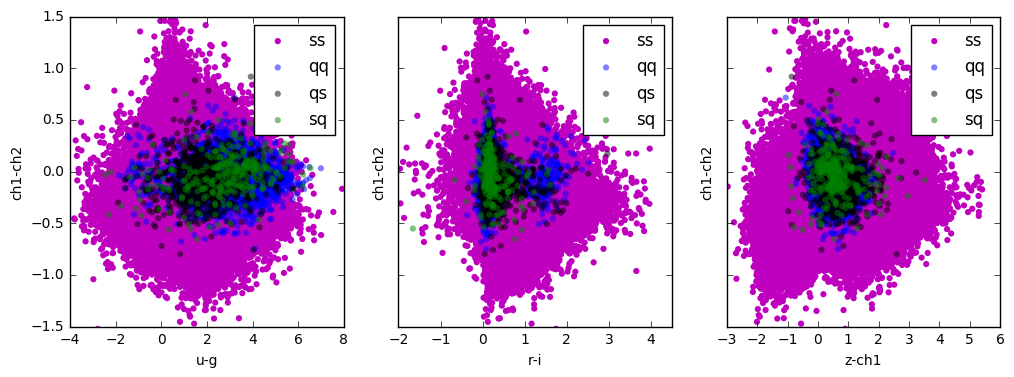

In [71]:
fig = plt.figure(figsize=(12, 4))
#fig.subplots_adjust(vspace=0.05)
ax1 = fig.add_subplot(131)
plt.scatter(datass['ug'],datass['s1s2'],label='ss',edgecolor='None',color='m')
plt.scatter(dataqq['ug'],dataqq['s1s2'],label='qq',edgecolor='None',color='b',alpha=0.5)
plt.scatter(dataqs['ug'],dataqs['s1s2'],label='qs',edgecolor='None',color='k',alpha=0.5)
plt.scatter(datasq['ug'],datasq['s1s2'],label='sq',edgecolor='None',color='g',alpha=0.5)
plt.legend(scatterpoints=1)
plt.xlim([-4,8])
plt.ylim([-1.5,1.5])
plt.xlabel('u-g')
plt.ylabel('ch1-ch2')

ax2 = fig.add_subplot(132)
ax2.yaxis.set_major_formatter(plt.NullFormatter())
plt.scatter(datass['ri'],datass['s1s2'],label='ss',edgecolor='None',color='m')
plt.scatter(dataqq['ri'],dataqq['s1s2'],label='qq',edgecolor='None',color='b',alpha=0.5)
plt.scatter(dataqs['ri'],dataqs['s1s2'],label='qs',edgecolor='None',color='k',alpha=0.5)
plt.scatter(datasq['ri'],datasq['s1s2'],label='sq',edgecolor='None',color='g',alpha=0.5)
plt.legend(scatterpoints=1)
plt.xlim([-2,4.5])
plt.ylim([-1.5,1.5])
plt.xlabel('r-i')
plt.ylabel('ch1-ch2')

ax3 = fig.add_subplot(133)
ax3.yaxis.set_major_formatter(plt.NullFormatter())
plt.scatter(datass['zs1'],datass['s1s2'],label='ss',edgecolor='None',color='m')
plt.scatter(dataqq['zs1'],dataqq['s1s2'],label='qq',edgecolor='None',color='b',alpha=0.5)
plt.scatter(dataqs['zs1'],dataqs['s1s2'],label='qs',edgecolor='None',color='k',alpha=0.5)
plt.scatter(datasq['zs1'],datasq['s1s2'],label='sq',edgecolor='None',color='g',alpha=0.5)
plt.legend(scatterpoints=1)
plt.xlim([-3,6])
plt.ylim([-1.5,1.5])
plt.xlabel('z-ch1')
plt.ylabel('ch1-ch2')

plt.show()

These are more revealing as contours or density plots (which I examined in TOPCAT), but I'm going to leave them as they are for now.

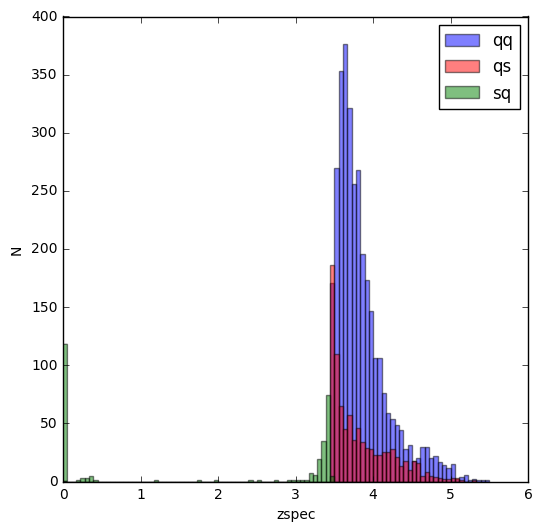

In [76]:
fig = plt.figure(figsize=(6, 6))
bins=np.linspace(0,5.5,100)
plt.hist(dataqq['zspec'],bins=bins,label='qq',color='b',alpha=0.5)
plt.hist(dataqs['zspec'],bins=bins,label='qs',color='r',alpha=0.5)
plt.hist(datasq['zspec'],bins=bins,label='sq',color='g',alpha=0.5)
#plt.xlim([-4,8])
#plt.ylim([-1.5,1.5])
plt.legend()
plt.xlabel('zspec')
plt.ylabel('N')

---

GTR: Stopped here.  Once a classifier is decided run it on the test data.  Memory and CPU time could be a problem.  We'll just have to see.

In [2]:
%matplotlib inline
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
data = Table.read('GTR-ADM-QSO-ir-testhighz_kdephotoz_lup_2016_quasar_candidates.zspec.fits')
Xtest = np.vstack([ data['ug'], data['gr'], data['ri'], data['iz'] ]).T
ytest = np.array(data['ZSPEC'])

In [4]:
data2 = Table.read('/Users/gtr/Work/sdss/mastercat/GTR-ADM-QSO-master-sweeps-Feb5-2016.zspeconly.fits')
# Get rid of objects with negative fluxes
mask = ( (data2['PSFFLUX'][:,0]>0) & (data2['PSFFLUX'][:,1]>0) & (data2['PSFFLUX'][:,2]>0) & (data2['PSFFLUX'][:,3]>0) & (data2['PSFFLUX'][:,4]>0)  )
data2 = data2[mask]